# MS960 - Aprendizado de Máquinas: Aspectos Teóricos e Práticos

## 2S2021 - Projeto II - Relatório prático da Rede Neural

Notebook com criação passo a passo da rede neural referente ao primeiro e quarto exercícios da parte 1.

### Grupo:

- **RA 155743 - Hugo Ricardo Ribeiro Matarozzi;**
- **RA 170093 - Isabella Mi Hyun Kim;**
- **RA 195171 - Bryan Alves do Prado.**

---

# Inicialização

In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
%matplotlib inline

In [2]:
filepath_imageMNIST = './imageMNIST.csv'
filepath_labelMNIST = './labelMNIST.csv'

---

# Redes Neurais

> Este projeto fará uso novamente da base de dígitos manuscritos MNIST, já
usada no Projeto 1.


## Implementação da rede neural

> Implemente uma rede neural regularizada com uma camada escondida como a vista em aula para resolver este problema. Considere usar, por exemplo, 25 “neurônios” na camada escondida. Mostre a porcentagem de imagens classificadas corretamente. Mostre também as imagens que a rede classificou incorretamente, juntamente com o dígito verdadeiro e o dígito que o classificador atribuiu. NOTA: Seu código deve funcionar também para um número qualquer de exemplos de treinamento, de classes, de camadas e de “neurônios”.

A implementação em módulos, no notebook, de uma rede neural regularizada depende de implementar, além de várias funções auxiliares, tanto o algoritmo para obter a previsão (_forward propagation_) quanto o algoritmo para treinamento (_backpropagation_). Podemos dividir nos passos:

1. **Definições preliminares**
    1. Definir função para criar matrizes X e Y (_load\_data_)
    2. Definir função sigmóide (_sigmoid_) e sua derivada (_sigmoid\_gradient_);    
    
    
2. **Previsão (_forward propagation_)**
    1. Definir função que implementa o _forward propagation_ (_forward\_propagation_);
    2. Definir função custo (_cost\_function_);
    
    
3. **Treinamento (_backpropagation_)**
    1. Definir função para cálculo de derivadas (_backpropagation_);
    2. Definir função para gradiente descendente (_gradient\_descent_);
    
    
4. **Execução e análise**
    1. Definir funções para inicialização de Thetas (_random\_weights_ e _theta\_initialization_);
    2. Definir função para treino (_train\_model_);
    3. Definir função para predição e avaliação de desempenho (_predict_ e _evaluate_) ;
    4. Definir função para exibição das imagens (_miss\_feedback_);
    5. Execução e discussão de resultados;
    6. Visualizar imagens de Θ(1).

### 1.A Definir função para criar matrizes X e Y (_load\_data_)

Primeiramente precisamos carregar nossos dados, já moldando-os para melhor uso. Em outras palavras, a coluna referente ao _bias_ será adicionada ao _X_, enquanto os valores de 10 serão substituídos por 0 no vetor _y_, que será depois transformado em uma matriz _Y_ compatível com o método de classificação multiclasses "um contra todos".

In [3]:
def load_data(filepath_images, filepath_labels):
    data_images = pd.read_csv(filepath_images)   
    X = data_images.values
    m,n = X.shape
    X = np.append(np.ones([m,1]), X, axis=1)  # add coluna bias
    
    data_labels = pd.read_csv(filepath_labels)
    y = data_labels.replace(10,0).values  # substituição 10 por 0
    
    # Criação de matriz Y -->
    nbr_classes = 10
    aux = []
    for i in range(m):
        aux.append(np.array([1 if y[i] == j else 0 for j in range(nbr_classes)]))
        
    Y = np.array(aux).reshape(-1, nbr_classes)
    # <--
    
    return X, Y, m, n, nbr_classes

### 1.B Definir função sigmóide (_sigmoid_) e sua derivada (_sigmoid\_gradient_)

Um dos primeiros passos que precisamos tomar é a definição da função sigmóide, que será a nossa função de ativação para a rede neural, além de sua derivada/gradiente.

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
def sigmoid_gradient(z):
    return (sigmoid(z)*(1-sigmoid(z)))

### 2.A Definir função que implementa o forward propagation (_forward\_propagation_)

Agora implementamos o algoritmo de _forward propagation_, realizando o percurso desde a entrada na rede até as saídas:

In [6]:
def forward_propagation(X, nbr_layers, Thetas):
    A=[]
    A.append(X)
    
    m = X.shape[0]
    for i in range(0, nbr_layers-2):
        a = sigmoid(A[-1] @ Thetas[i].T)  # g(z)
        a = np.hstack((np.ones((m,1)), a))  # add coluna bias
        A.append(a)
        
    A.append(sigmoid(A[-1] @ Thetas[-1].T))  # add h
    
    return A

### 2.B Definir função custo (_cost\_function_)

Definimos nossa função custo específica para o caso de nossa rede neural, regularizada e de função de ativação sigmóide. Temos:

In [7]:
def cost_function(Y, A, Thetas, m, nbr_classes, lambda_):
    h = A[-1]
    J = (-1/m)*sum(np.diag(Y.T @ np.log(h) + (1-Y).T @ np.log(1-h)))  # função custo
    
    for Theta in Thetas:
        J += ((lambda_)/(2*m))*sum(np.diag(Theta[1:].T @ Theta[1:]))  # add termo regularização
        
    return J 

### 3.A Definir função para cálculo de derivadas (_backpropagation_)

Finalmente começamos a considerar o treinamento de nossa rede neural. Primeiramente, precisamos implementar o algoritmo de _backpropagation_, para calcular as derivadas a serem usadas no gradiente descendente.

In [8]:
def backpropagation(X, Y, A, Thetas, lambda_):
    Grads = []
    Deltas = []
    
    Delta = A[-1] - Y  # d(L)
    
    Grad = Delta.T @ A[-2] 
    Grads.append(Grad)
    
    Deltas.append(Delta)
    
    # cálculo de d(l)'s intermediários -->
    for i in range(len(Thetas)-2, 0, -1):
        Delta = np.multiply((Deltas[-1] @ Thetas[i+1][:,1:]),(sigmoid_gradient(A[i-1] @ Thetas[i].T)))
        Grad = Delta.T @ A[i-1]
        Deltas.append(Delta)
        Grads.append(Grad)
    # <--
    
    # cálculo do último d(l) -->
    Delta = np.multiply((Deltas[-1] @ Thetas[1][:,1:]),(sigmoid_gradient(X @ Thetas[0].T)))
    Grad = Delta.T @ X
    Deltas.append(Delta)
    Grads.append(Grad)
    # <--
    
    Grads, Deltas = list(reversed(Grads)), list(reversed(Deltas))
    for r in range(0, len(Grads)):
        Grads[r] = (1/m)*Grads[r]  # calculando a média
        Grads[r] = Grads[r] + (lambda_/m)*np.hstack((np.zeros((Thetas[r].shape[0],1)),Thetas[r][:,1:])) # add termo regularização
    
    return Grads, Deltas

### 3.B Definir função para gradiente descendente (_gradient\_descent_)
Finalmente, com o gradiente regularizado obtido pela _backpropagation_, podemos realizar o treinamento por gradiente descendente.

In [9]:
def gradient_descent(X, Y, Thetas, m, n, alpha, lambda_, nbr_layers, nbr_iter, nbr_classes):
    J_history = []
    
    for i in range(nbr_iter):
        A = forward_propagation(X, nbr_layers, Thetas)
        J = cost_function(Y, A, Thetas, m, nbr_classes, lambda_)
        Grads, Deltas = backpropagation(X, Y, A, Thetas, lambda_)
        
        for j in range(len(Thetas)):
            Thetas[j] = Thetas[j] - alpha*Grads[j]  # atualização dos thetas
            
        J_history.append(J)
        
    return Thetas, J_history, A, Grads, Deltas  

### 4.A Definir funções para inicialização de Thetas (_random\_weights_ e _theta\_initialization_)

Agora precisamos criar matrizes _Theta_ aleatórias, para a quebra de simetria do problema. Primeiramente, criamos os valores aleatórios em _random\_weights_, e depois inicializamos os Thetas com _theta\_initialization_.

In [10]:
def random_weight(hidden_layer_sizes, nbr_layers):
    i = (6**(1/2)) / ((hidden_layer_sizes + nbr_layers)**(1/2))
    
    return np.random.rand(nbr_layers,hidden_layer_sizes+1)*(2*i)-i

In [11]:
def theta_initialization(X, Y, hidden_layer_sizes, nbr_layers):
    Thetas = []   
    Thetas.append(random_weight(X.shape[1]-1,hidden_layer_sizes[0]))
    
    for i in range(1,nbr_layers-2):
        Thetas.append(random_weight(hidden_layer_sizes[i-1],hidden_layer_sizes[i]))
        
    Thetas.append(random_weight(hidden_layer_sizes[-1],Y.shape[1]))
    
    return Thetas

### 4.B Definir função para treino (_train\_model_)

Finalmente, treinamos nosso modelo com o gradiente descendente:

In [12]:
def train_model(X, Y, m, n, alpha, lambda_, hidden_layer_sizes, nbr_layers, nbr_iter,  nbr_classes):
    Thetas = theta_initialization(X, Y, hidden_layer_sizes, nbr_layers)
    new_Thetas, J_history, A ,Grads, Deltas = gradient_descent(X, Y, Thetas, m, n, alpha, lambda_, nbr_layers, nbr_iter,  nbr_classes)
    
    return new_Thetas, J_history

### 4.C Definir função para predição e avaliação de desempenho (_predict_ e _evaluate_) 

Com nosso modelo treinado, podemos realização as previsões e avaliar a precisão:

In [13]:
def predict(X, Y, Thetas, m, nbr_layers):
    A = forward_propagation(X, nbr_layers, Thetas)
    
    pred = np.argmax(A[-1], axis=1)
    np.array(pred).reshape((m, 1))
    y = np.argmax(Y,axis=1)
    correct = sum(pred == y)
            
    return pred, y, correct

In [14]:
def evaluate(m, correct):
    return correct/m*100

### 4.D Definir função para exibição das imagens (_miss\_feedback_);

Por fim, a última função a ser definida nessa etapa é o feedback visual dos erros _miss\_feedback_:

In [15]:
def miss_feedback(X, Y, pred):
    m = len(Y)
    y_labels = []
    for row in Y:
        y_labels.append(np.argmax(row))        
    y_labels = np.array(y_labels).reshape((m, 1))
    
    for i in range(m):
        if not (y_labels[i] == pred[i]):
            print(f'Label: \t {y_labels[i]}')
            print(f'Predição: {pred[i]}')
            pixels = X[i, 1:].reshape((20, 20))
            plt.imshow(pixels, cmap='hot')
            plt.show()
            print('----------------------------------') 

### 4.E Execução e discussão de resultados

Agora podemos realizar nossos testes para os valores pedidos: 

- número de camadas = 3 (1 escondida);
- tamanho da(s) camada(s) escondida(s) = 25;

usando os parâmetros:

- número de iterações = 800
- taxa de aprendizado = 0.8
- taxa de regularização = 1

In [16]:
X, Y, m, n, nbr_classes = load_data(filepath_imageMNIST, filepath_labelMNIST)
nbr_layers = 3
hidden_layer_sizes = [25]
nbr_iter = 800
alpha = 0.8
lambda_ = 1

new_Thetas, J_history = train_model(X, Y, m, n, alpha, lambda_, hidden_layer_sizes, nbr_layers, nbr_iter, nbr_classes)

In [17]:
pred, y, correct = predict(X, Y, new_Thetas, m, nbr_layers)
percentage = evaluate(m, correct)
print(f'Accuracy = {percentage:.2f}%')

Accuracy = 94.74%


Label: 	 [0]
Predição: 3


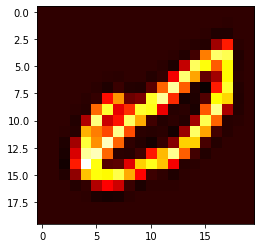

----------------------------------
Label: 	 [0]
Predição: 8


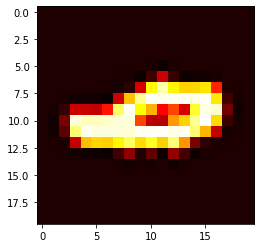

----------------------------------
Label: 	 [0]
Predição: 6


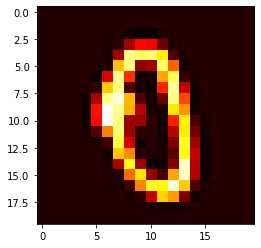

----------------------------------
Label: 	 [0]
Predição: 4


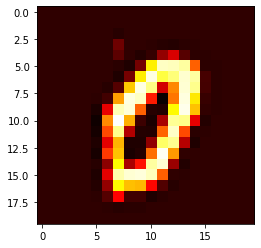

----------------------------------
Label: 	 [0]
Predição: 3


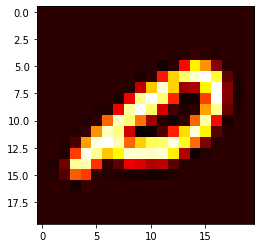

----------------------------------
Label: 	 [0]
Predição: 6


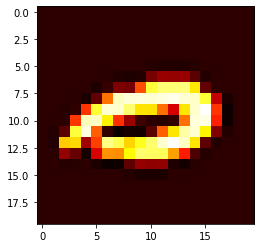

----------------------------------
Label: 	 [1]
Predição: 5


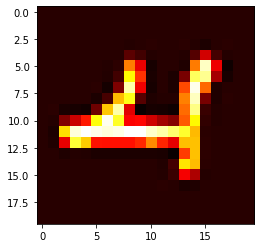

----------------------------------
Label: 	 [1]
Predição: 2


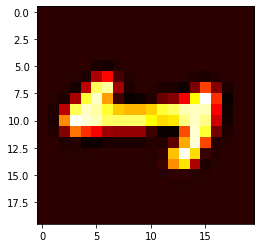

----------------------------------
Label: 	 [1]
Predição: 4


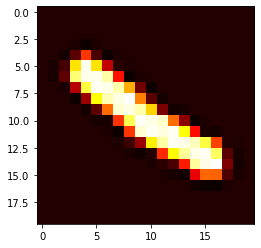

----------------------------------
Label: 	 [1]
Predição: 7


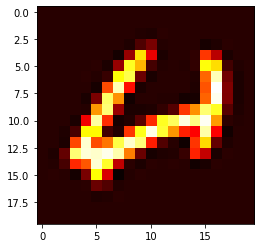

----------------------------------
Label: 	 [1]
Predição: 5


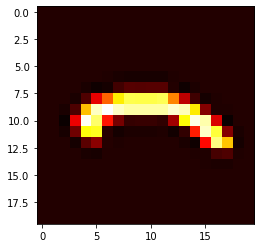

----------------------------------
Label: 	 [1]
Predição: 7


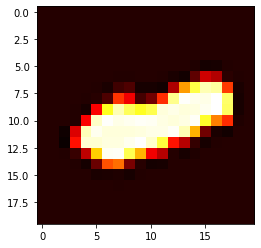

----------------------------------
Label: 	 [1]
Predição: 8


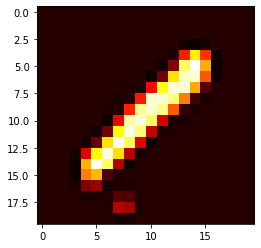

----------------------------------
Label: 	 [1]
Predição: 2


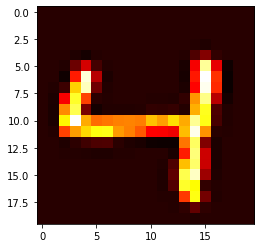

----------------------------------
Label: 	 [1]
Predição: 4


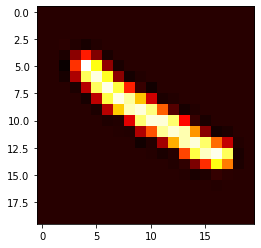

----------------------------------
Label: 	 [1]
Predição: 5


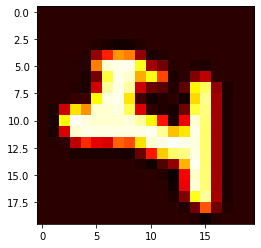

----------------------------------
Label: 	 [2]
Predição: 6


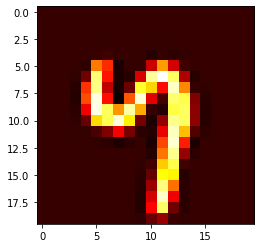

----------------------------------
Label: 	 [2]
Predição: 0


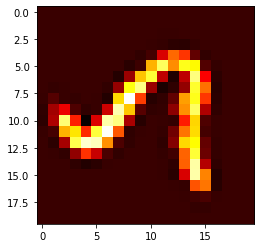

----------------------------------
Label: 	 [2]
Predição: 7


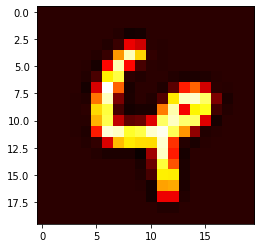

----------------------------------
Label: 	 [2]
Predição: 3


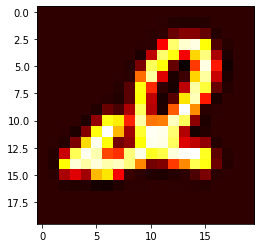

----------------------------------
Label: 	 [2]
Predição: 1


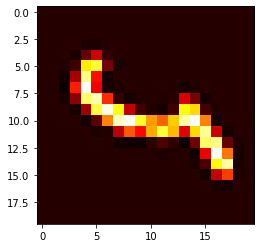

----------------------------------
Label: 	 [2]
Predição: 5


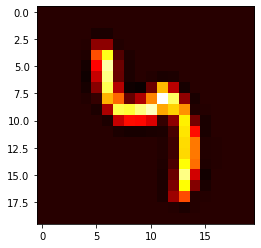

----------------------------------
Label: 	 [2]
Predição: 1


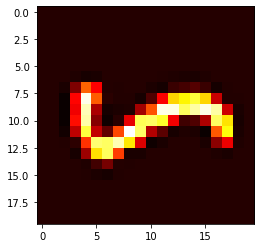

----------------------------------
Label: 	 [2]
Predição: 9


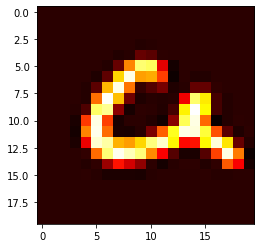

----------------------------------
Label: 	 [2]
Predição: 3


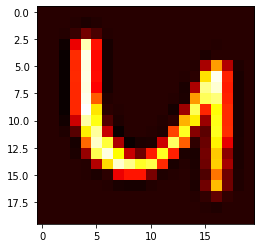

----------------------------------
Label: 	 [2]
Predição: 8


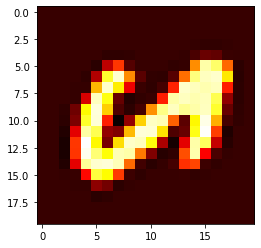

----------------------------------
Label: 	 [2]
Predição: 7


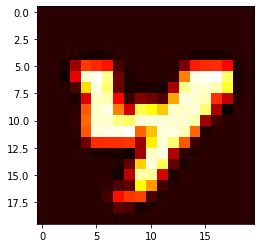

----------------------------------
Label: 	 [2]
Predição: 8


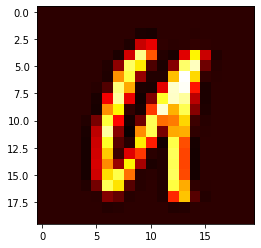

----------------------------------
Label: 	 [2]
Predição: 1


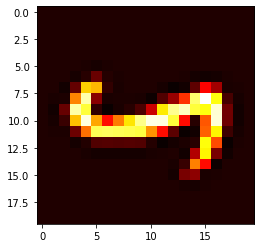

----------------------------------
Label: 	 [2]
Predição: 4


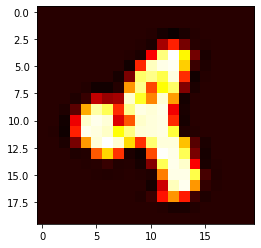

----------------------------------
Label: 	 [2]
Predição: 9


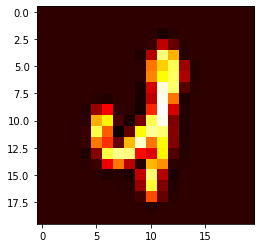

----------------------------------
Label: 	 [2]
Predição: 8


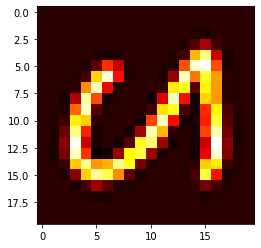

----------------------------------
Label: 	 [2]
Predição: 3


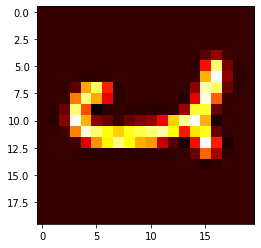

----------------------------------
Label: 	 [2]
Predição: 6


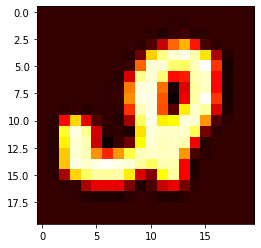

----------------------------------
Label: 	 [2]
Predição: 4


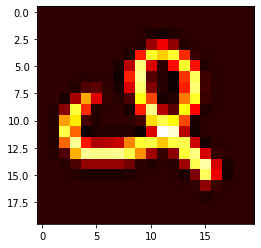

----------------------------------
Label: 	 [2]
Predição: 8


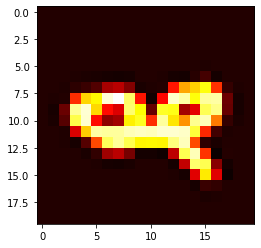

----------------------------------
Label: 	 [2]
Predição: 8


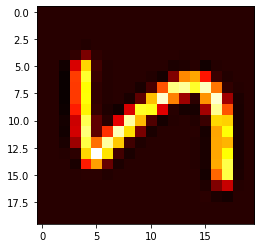

----------------------------------
Label: 	 [2]
Predição: 0


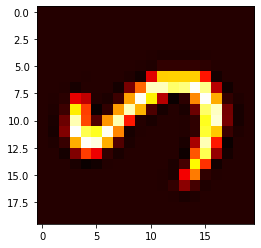

----------------------------------
Label: 	 [2]
Predição: 8


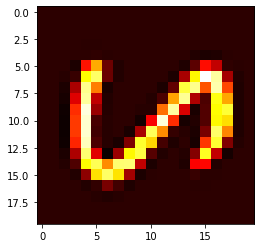

----------------------------------
Label: 	 [2]
Predição: 6


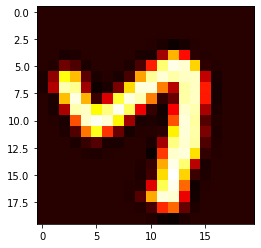

----------------------------------
Label: 	 [2]
Predição: 3


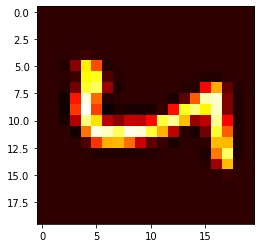

----------------------------------
Label: 	 [2]
Predição: 8


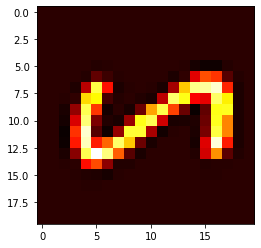

----------------------------------
Label: 	 [2]
Predição: 4


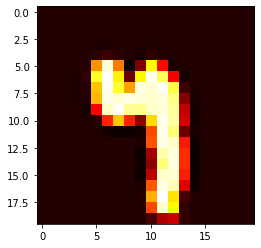

----------------------------------
Label: 	 [2]
Predição: 0


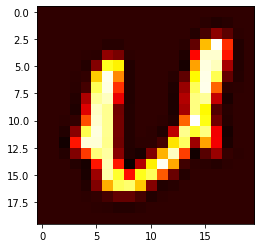

----------------------------------
Label: 	 [2]
Predição: 8


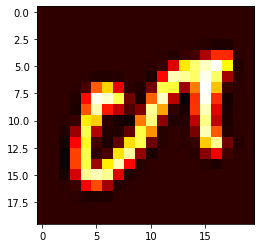

----------------------------------
Label: 	 [2]
Predição: 8


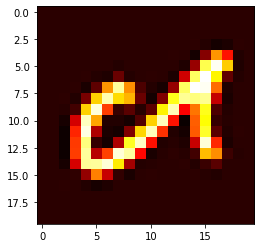

----------------------------------
Label: 	 [2]
Predição: 8


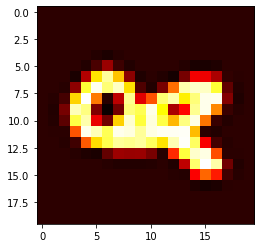

----------------------------------
Label: 	 [2]
Predição: 6


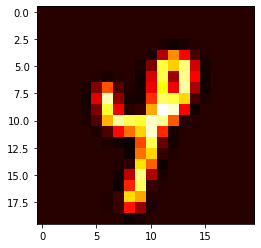

----------------------------------
Label: 	 [2]
Predição: 6


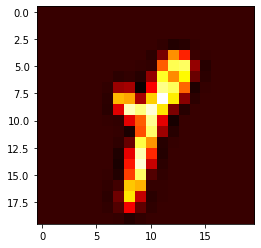

----------------------------------
Label: 	 [2]
Predição: 6


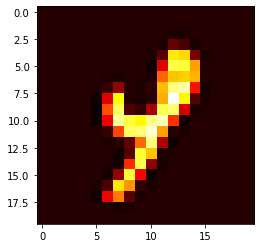

----------------------------------
Label: 	 [2]
Predição: 4


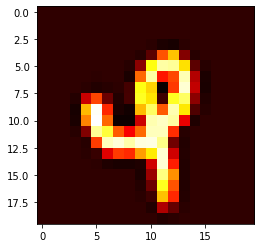

----------------------------------
Label: 	 [2]
Predição: 4


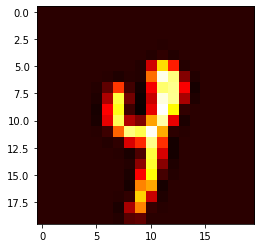

----------------------------------
Label: 	 [2]
Predição: 8


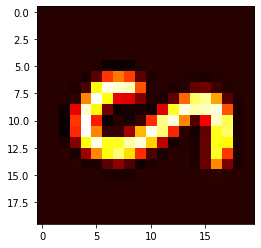

----------------------------------
Label: 	 [2]
Predição: 1


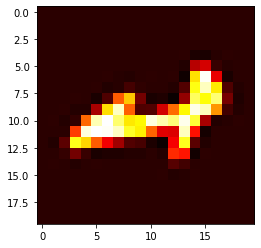

----------------------------------
Label: 	 [2]
Predição: 6


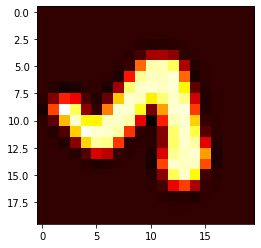

----------------------------------
Label: 	 [2]
Predição: 7


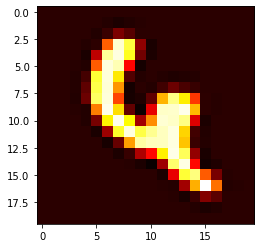

----------------------------------
Label: 	 [2]
Predição: 3


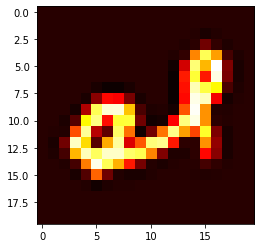

----------------------------------
Label: 	 [2]
Predição: 5


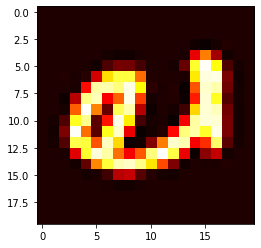

----------------------------------
Label: 	 [2]
Predição: 0


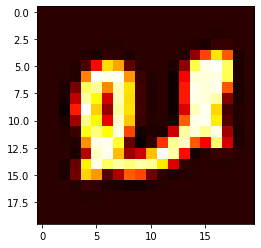

----------------------------------
Label: 	 [2]
Predição: 0


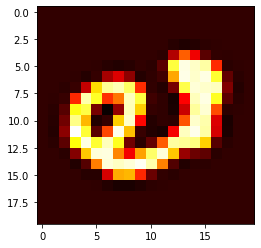

----------------------------------
Label: 	 [2]
Predição: 0


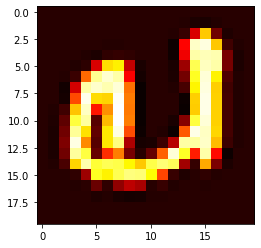

----------------------------------
Label: 	 [3]
Predição: 5


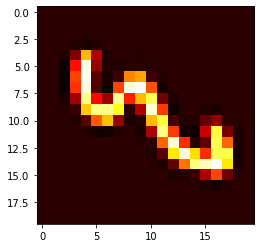

----------------------------------
Label: 	 [3]
Predição: 7


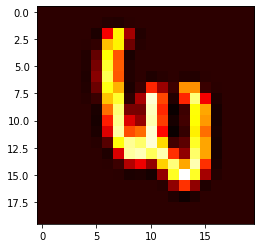

----------------------------------
Label: 	 [3]
Predição: 7


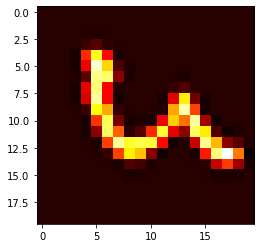

----------------------------------
Label: 	 [3]
Predição: 2


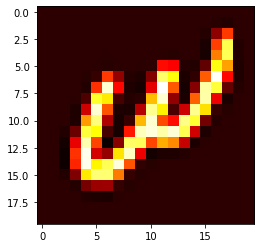

----------------------------------
Label: 	 [3]
Predição: 2


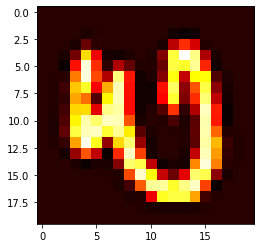

----------------------------------
Label: 	 [3]
Predição: 6


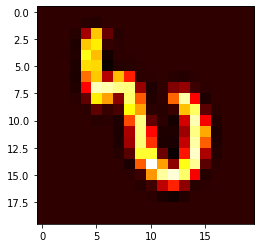

----------------------------------
Label: 	 [3]
Predição: 2


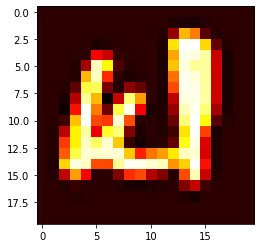

----------------------------------
Label: 	 [3]
Predição: 5


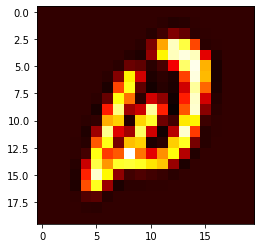

----------------------------------
Label: 	 [3]
Predição: 5


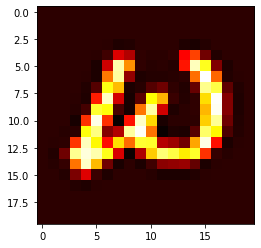

----------------------------------
Label: 	 [3]
Predição: 8


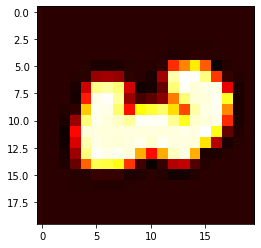

----------------------------------
Label: 	 [3]
Predição: 9


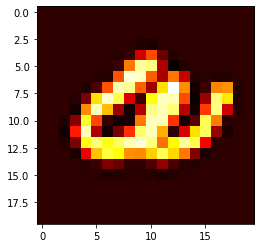

----------------------------------
Label: 	 [3]
Predição: 5


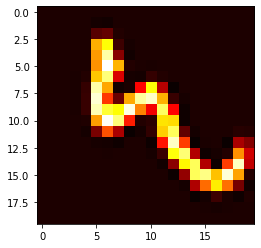

----------------------------------
Label: 	 [3]
Predição: 2


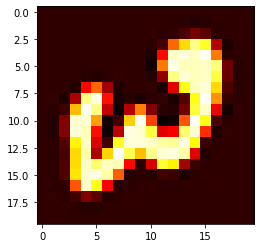

----------------------------------
Label: 	 [3]
Predição: 2


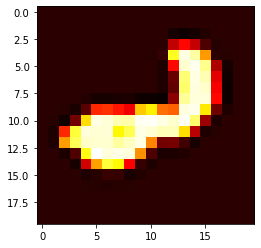

----------------------------------
Label: 	 [3]
Predição: 2


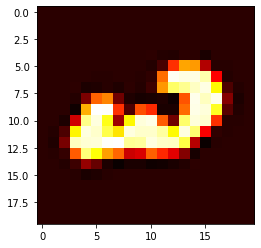

----------------------------------
Label: 	 [3]
Predição: 5


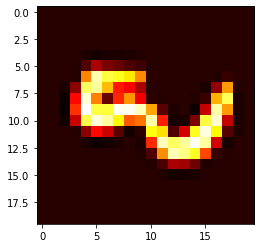

----------------------------------
Label: 	 [3]
Predição: 5


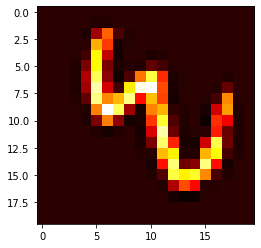

----------------------------------
Label: 	 [3]
Predição: 7


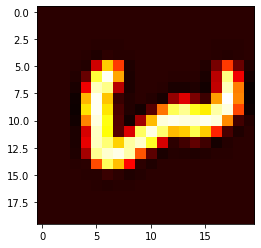

----------------------------------
Label: 	 [3]
Predição: 1


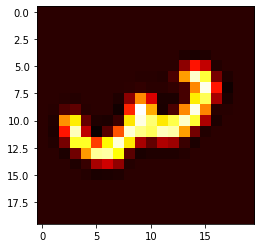

----------------------------------
Label: 	 [3]
Predição: 8


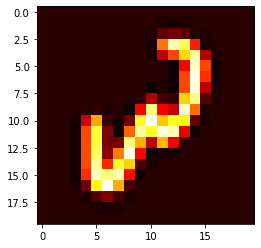

----------------------------------
Label: 	 [3]
Predição: 5


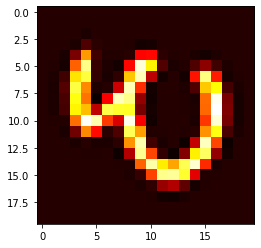

----------------------------------
Label: 	 [3]
Predição: 5


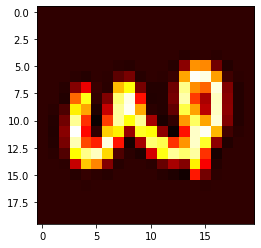

----------------------------------
Label: 	 [3]
Predição: 2


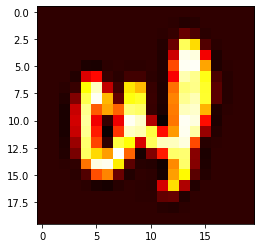

----------------------------------
Label: 	 [3]
Predição: 7


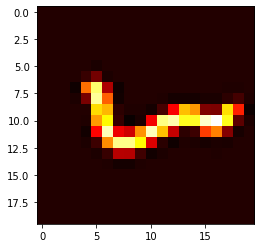

----------------------------------
Label: 	 [3]
Predição: 5


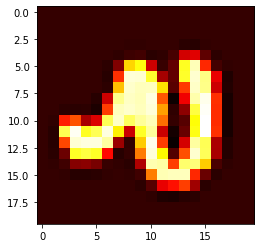

----------------------------------
Label: 	 [3]
Predição: 8


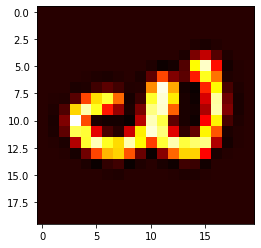

----------------------------------
Label: 	 [3]
Predição: 5


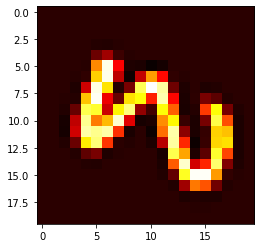

----------------------------------
Label: 	 [3]
Predição: 7


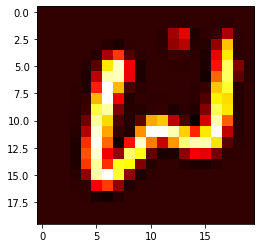

----------------------------------
Label: 	 [3]
Predição: 1


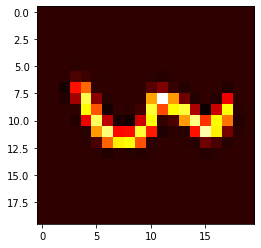

----------------------------------
Label: 	 [3]
Predição: 2


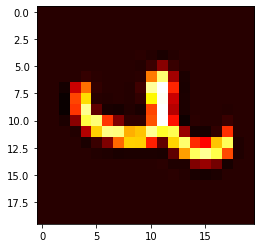

----------------------------------
Label: 	 [3]
Predição: 5


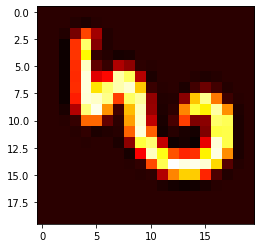

----------------------------------
Label: 	 [3]
Predição: 5


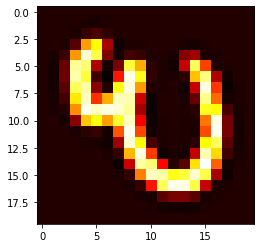

----------------------------------
Label: 	 [3]
Predição: 9


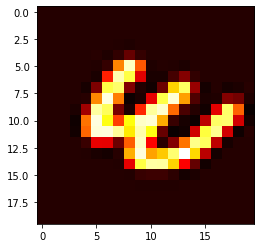

----------------------------------
Label: 	 [3]
Predição: 5


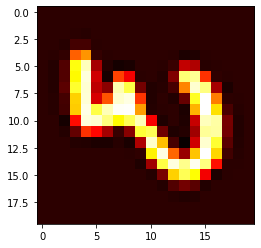

----------------------------------
Label: 	 [3]
Predição: 1


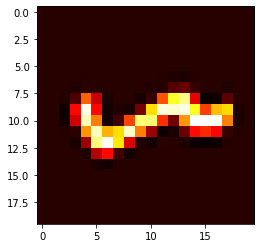

----------------------------------
Label: 	 [3]
Predição: 5


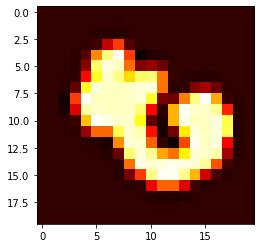

----------------------------------
Label: 	 [3]
Predição: 7


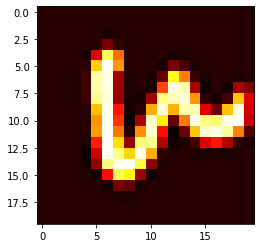

----------------------------------
Label: 	 [3]
Predição: 8


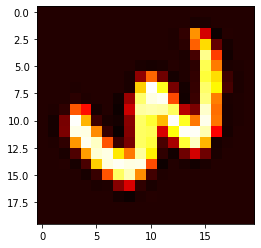

----------------------------------
Label: 	 [3]
Predição: 5


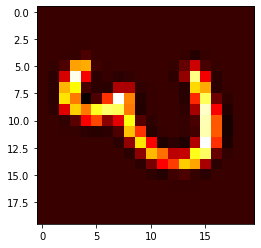

----------------------------------
Label: 	 [3]
Predição: 7


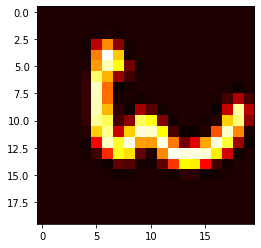

----------------------------------
Label: 	 [3]
Predição: 2


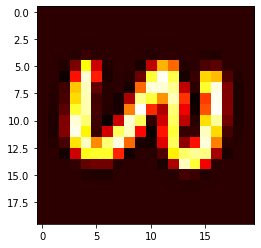

----------------------------------
Label: 	 [4]
Predição: 9


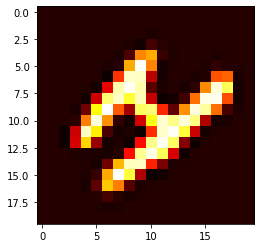

----------------------------------
Label: 	 [4]
Predição: 2


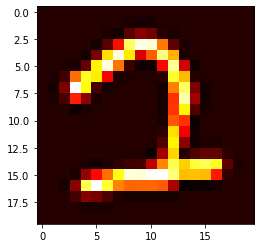

----------------------------------
Label: 	 [4]
Predição: 6


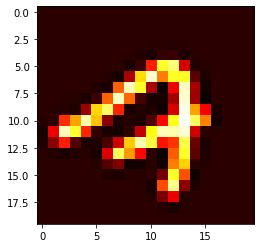

----------------------------------
Label: 	 [4]
Predição: 9


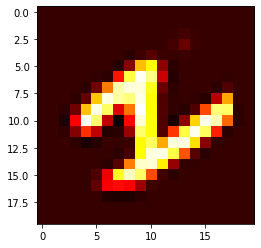

----------------------------------
Label: 	 [4]
Predição: 1


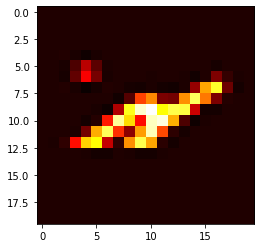

----------------------------------
Label: 	 [4]
Predição: 1


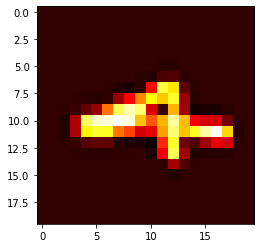

----------------------------------
Label: 	 [4]
Predição: 9


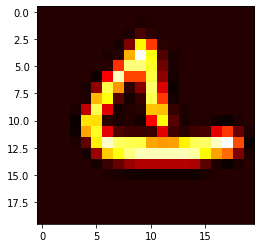

----------------------------------
Label: 	 [4]
Predição: 9


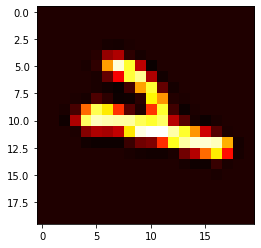

----------------------------------
Label: 	 [4]
Predição: 2


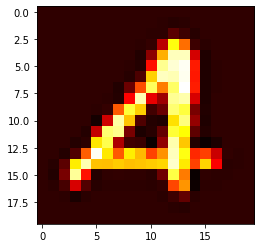

----------------------------------
Label: 	 [4]
Predição: 9


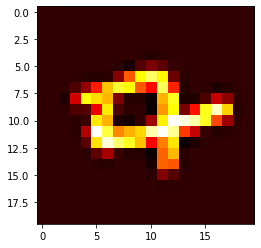

----------------------------------
Label: 	 [4]
Predição: 9


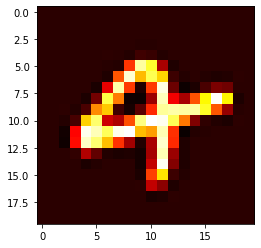

----------------------------------
Label: 	 [4]
Predição: 2


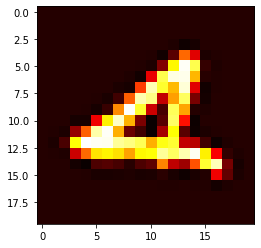

----------------------------------
Label: 	 [4]
Predição: 9


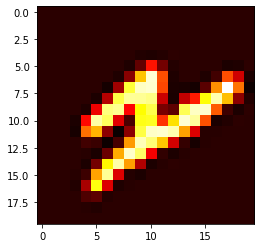

----------------------------------
Label: 	 [4]
Predição: 8


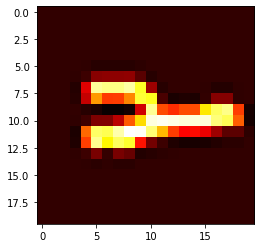

----------------------------------
Label: 	 [4]
Predição: 0


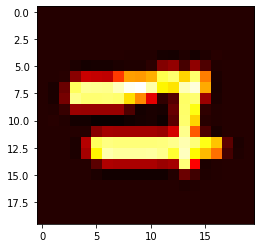

----------------------------------
Label: 	 [4]
Predição: 6


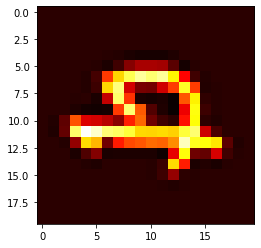

----------------------------------
Label: 	 [4]
Predição: 6


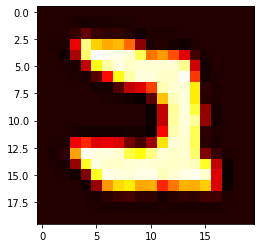

----------------------------------
Label: 	 [4]
Predição: 9


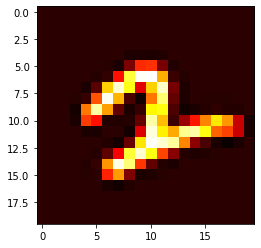

----------------------------------
Label: 	 [4]
Predição: 6


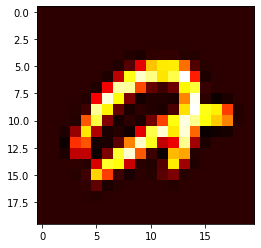

----------------------------------
Label: 	 [4]
Predição: 9


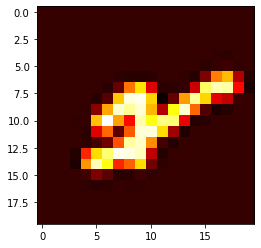

----------------------------------
Label: 	 [5]
Predição: 3


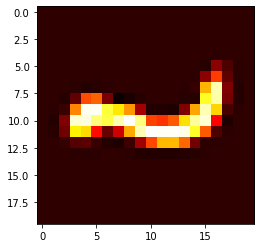

----------------------------------
Label: 	 [5]
Predição: 2


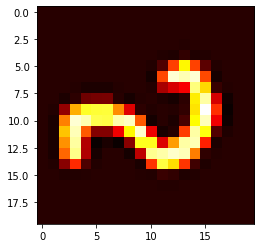

----------------------------------
Label: 	 [5]
Predição: 9


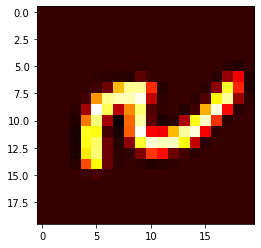

----------------------------------
Label: 	 [5]
Predição: 2


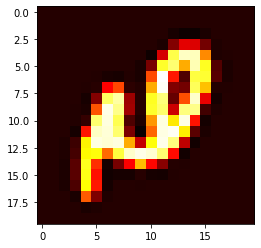

----------------------------------
Label: 	 [5]
Predição: 4


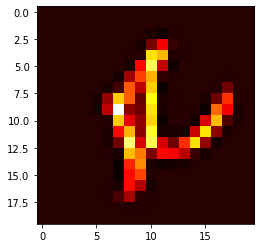

----------------------------------
Label: 	 [5]
Predição: 8


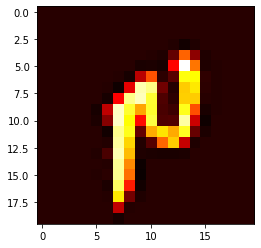

----------------------------------
Label: 	 [5]
Predição: 8


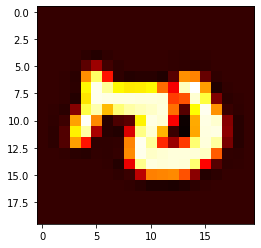

----------------------------------
Label: 	 [5]
Predição: 3


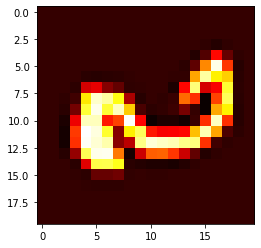

----------------------------------
Label: 	 [5]
Predição: 6


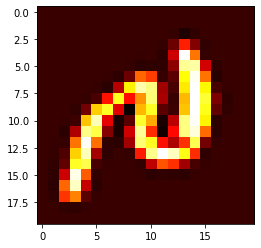

----------------------------------
Label: 	 [5]
Predição: 6


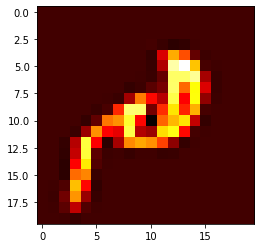

----------------------------------
Label: 	 [5]
Predição: 3


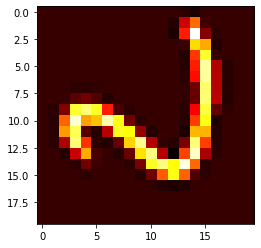

----------------------------------
Label: 	 [5]
Predição: 6


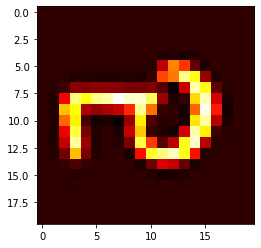

----------------------------------
Label: 	 [5]
Predição: 8


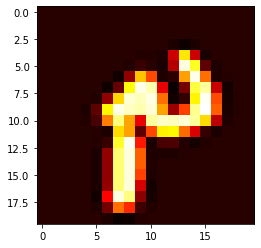

----------------------------------
Label: 	 [5]
Predição: 3


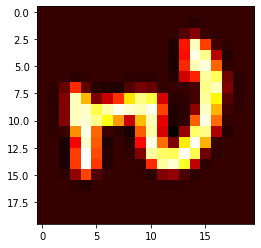

----------------------------------
Label: 	 [5]
Predição: 0


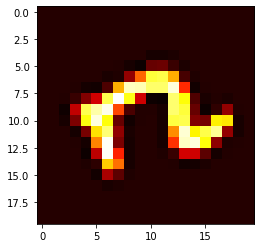

----------------------------------
Label: 	 [5]
Predição: 0


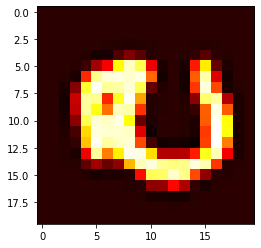

----------------------------------
Label: 	 [5]
Predição: 4


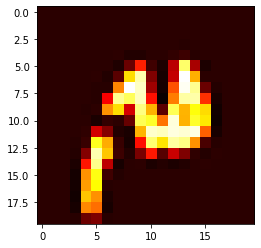

----------------------------------
Label: 	 [5]
Predição: 3


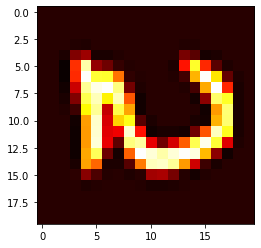

----------------------------------
Label: 	 [5]
Predição: 6


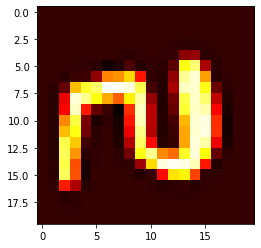

----------------------------------
Label: 	 [5]
Predição: 3


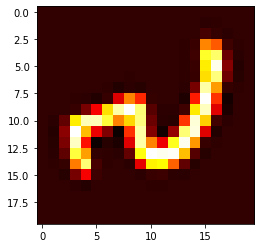

----------------------------------
Label: 	 [5]
Predição: 3


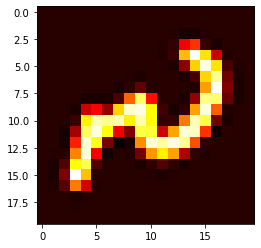

----------------------------------
Label: 	 [5]
Predição: 2


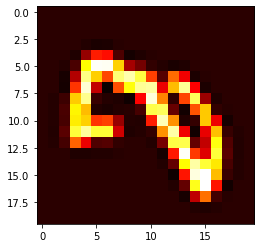

----------------------------------
Label: 	 [5]
Predição: 3


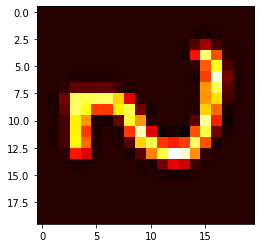

----------------------------------
Label: 	 [5]
Predição: 0


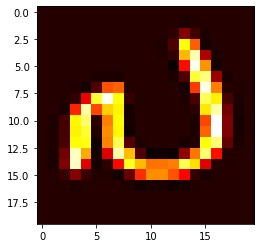

----------------------------------
Label: 	 [5]
Predição: 0


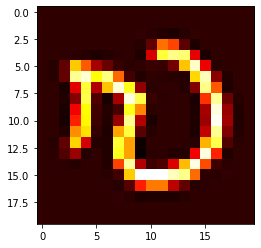

----------------------------------
Label: 	 [5]
Predição: 1


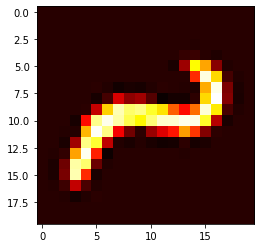

----------------------------------
Label: 	 [5]
Predição: 9


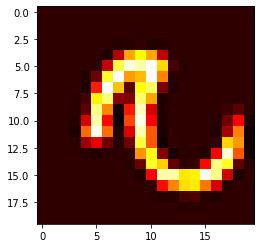

----------------------------------
Label: 	 [5]
Predição: 9


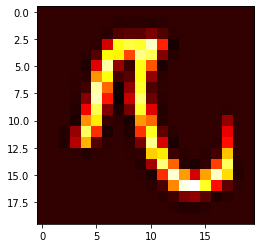

----------------------------------
Label: 	 [5]
Predição: 0


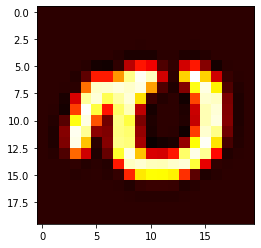

----------------------------------
Label: 	 [5]
Predição: 6


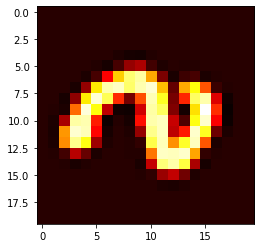

----------------------------------
Label: 	 [5]
Predição: 8


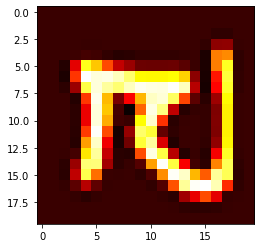

----------------------------------
Label: 	 [5]
Predição: 0


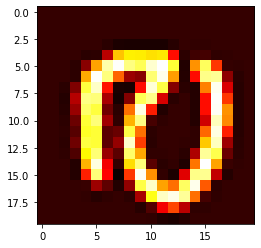

----------------------------------
Label: 	 [5]
Predição: 4


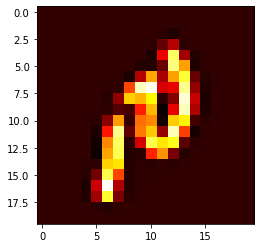

----------------------------------
Label: 	 [5]
Predição: 8


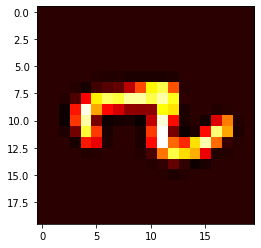

----------------------------------
Label: 	 [5]
Predição: 4


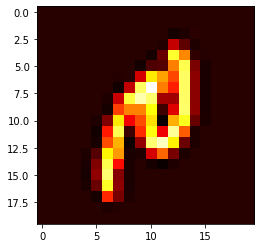

----------------------------------
Label: 	 [5]
Predição: 8


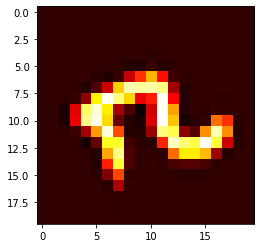

----------------------------------
Label: 	 [5]
Predição: 3


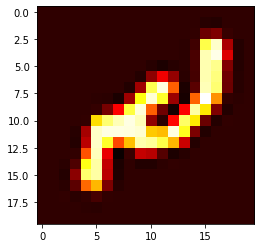

----------------------------------
Label: 	 [6]
Predição: 0


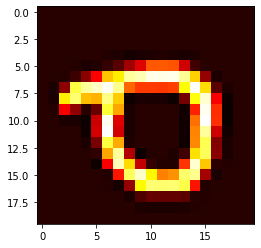

----------------------------------
Label: 	 [6]
Predição: 0


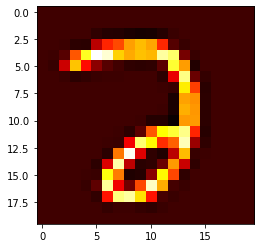

----------------------------------
Label: 	 [6]
Predição: 8


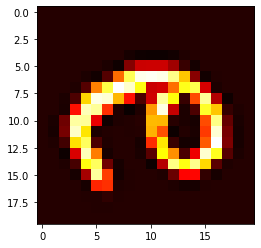

----------------------------------
Label: 	 [6]
Predição: 1


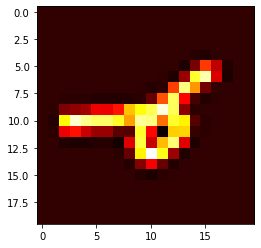

----------------------------------
Label: 	 [6]
Predição: 0


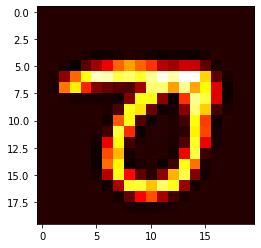

----------------------------------
Label: 	 [6]
Predição: 5


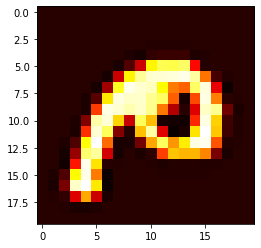

----------------------------------
Label: 	 [6]
Predição: 1


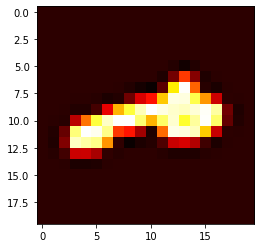

----------------------------------
Label: 	 [6]
Predição: 5


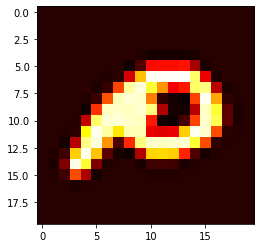

----------------------------------
Label: 	 [6]
Predição: 4


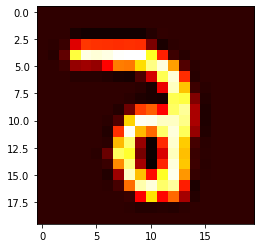

----------------------------------
Label: 	 [6]
Predição: 8


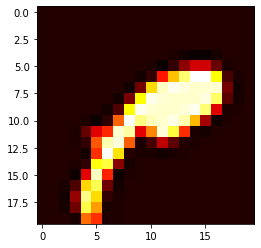

----------------------------------
Label: 	 [6]
Predição: 5


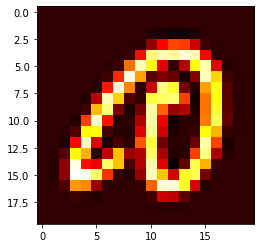

----------------------------------
Label: 	 [6]
Predição: 5


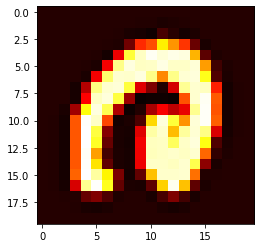

----------------------------------
Label: 	 [6]
Predição: 0


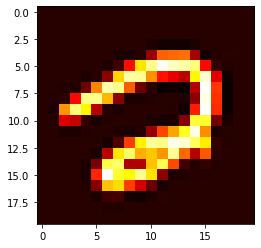

----------------------------------
Label: 	 [6]
Predição: 5


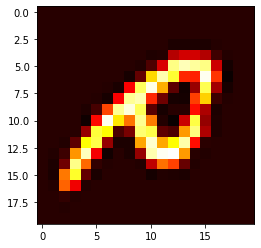

----------------------------------
Label: 	 [6]
Predição: 2


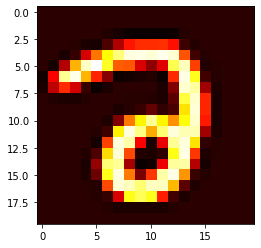

----------------------------------
Label: 	 [6]
Predição: 8


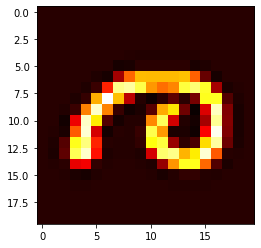

----------------------------------
Label: 	 [6]
Predição: 5


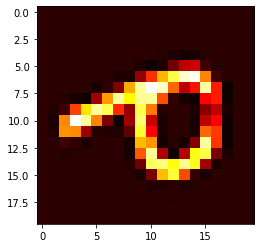

----------------------------------
Label: 	 [7]
Predição: 9


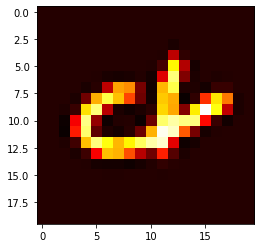

----------------------------------
Label: 	 [7]
Predição: 9


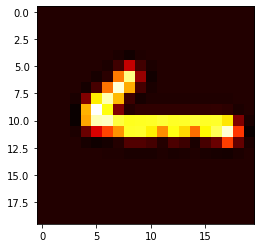

----------------------------------
Label: 	 [7]
Predição: 1


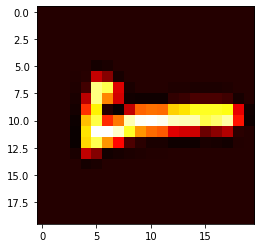

----------------------------------
Label: 	 [7]
Predição: 2


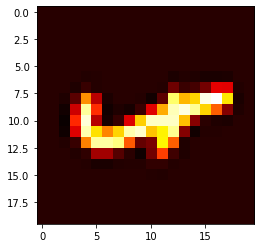

----------------------------------
Label: 	 [7]
Predição: 4


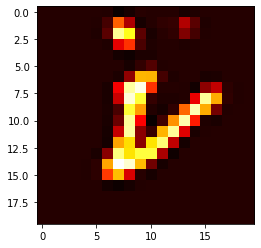

----------------------------------
Label: 	 [7]
Predição: 4


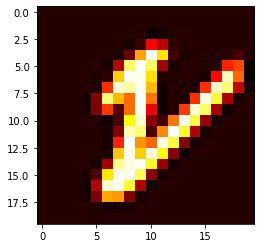

----------------------------------
Label: 	 [7]
Predição: 4


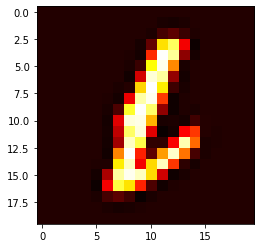

----------------------------------
Label: 	 [7]
Predição: 4


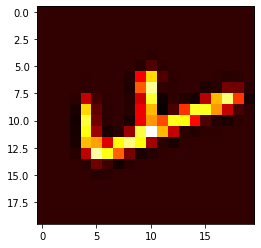

----------------------------------
Label: 	 [7]
Predição: 0


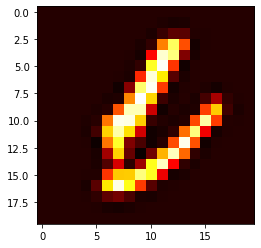

----------------------------------
Label: 	 [7]
Predição: 9


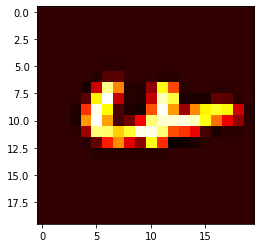

----------------------------------
Label: 	 [7]
Predição: 4


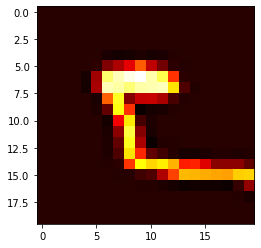

----------------------------------
Label: 	 [7]
Predição: 9


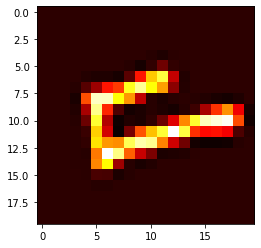

----------------------------------
Label: 	 [7]
Predição: 0


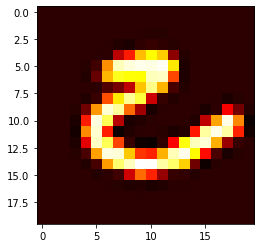

----------------------------------
Label: 	 [7]
Predição: 2


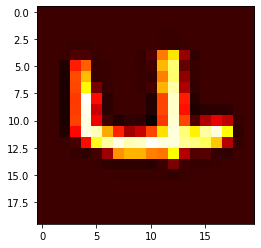

----------------------------------
Label: 	 [7]
Predição: 2


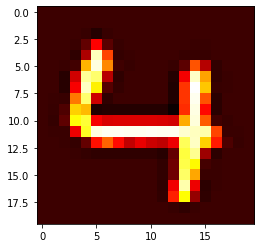

----------------------------------
Label: 	 [7]
Predição: 9


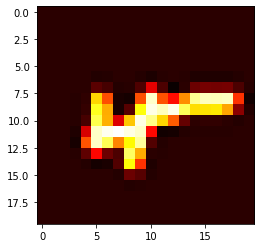

----------------------------------
Label: 	 [7]
Predição: 1


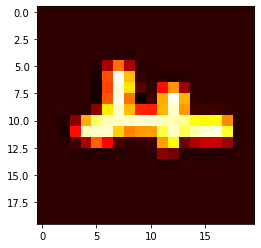

----------------------------------
Label: 	 [7]
Predição: 9


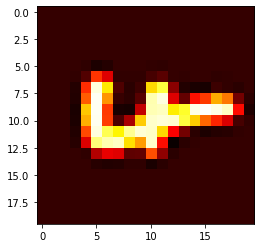

----------------------------------
Label: 	 [7]
Predição: 1


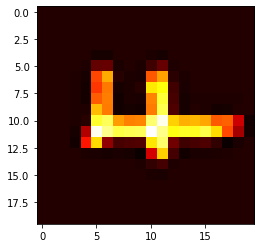

----------------------------------
Label: 	 [7]
Predição: 1


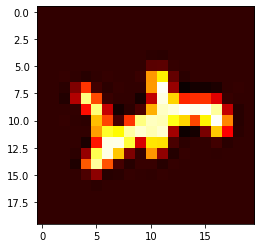

----------------------------------
Label: 	 [7]
Predição: 1


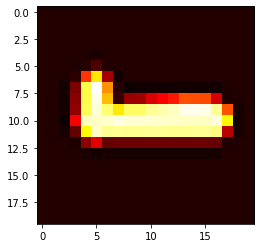

----------------------------------
Label: 	 [7]
Predição: 3


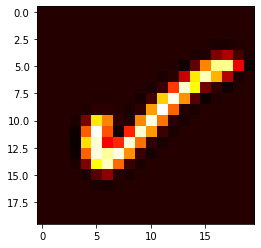

----------------------------------
Label: 	 [7]
Predição: 9


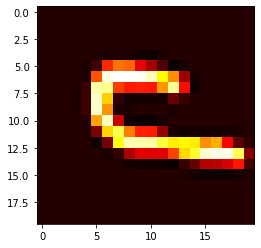

----------------------------------
Label: 	 [8]
Predição: 3


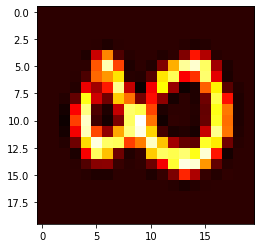

----------------------------------
Label: 	 [8]
Predição: 2


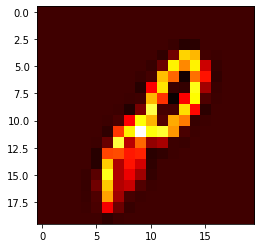

----------------------------------
Label: 	 [8]
Predição: 6


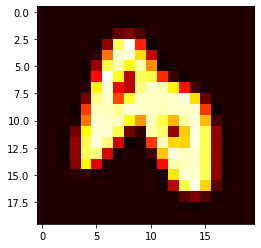

----------------------------------
Label: 	 [8]
Predição: 6


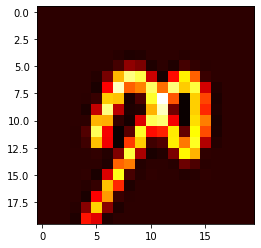

----------------------------------
Label: 	 [8]
Predição: 1


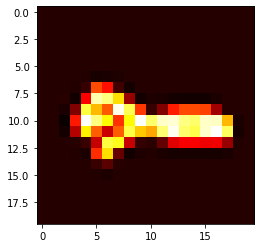

----------------------------------
Label: 	 [8]
Predição: 2


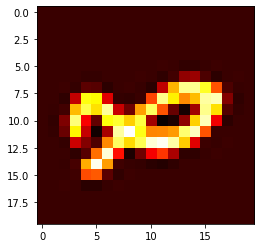

----------------------------------
Label: 	 [8]
Predição: 1


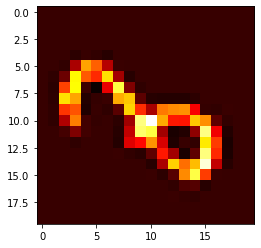

----------------------------------
Label: 	 [8]
Predição: 7


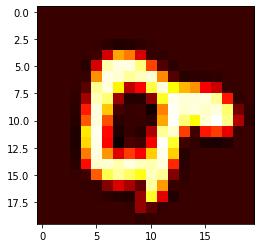

----------------------------------
Label: 	 [8]
Predição: 5


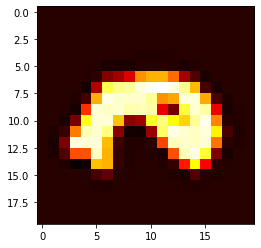

----------------------------------
Label: 	 [8]
Predição: 3


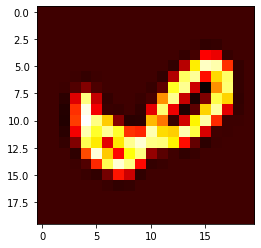

----------------------------------
Label: 	 [8]
Predição: 9


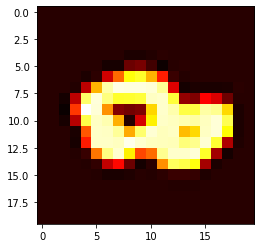

----------------------------------
Label: 	 [8]
Predição: 1


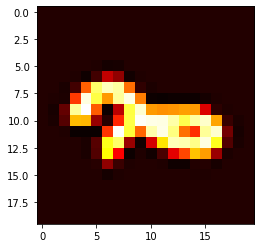

----------------------------------
Label: 	 [8]
Predição: 9


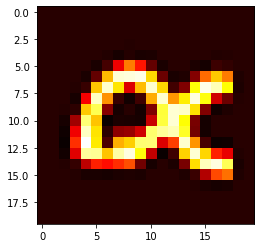

----------------------------------
Label: 	 [8]
Predição: 0


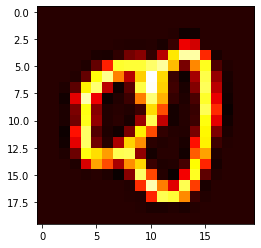

----------------------------------
Label: 	 [8]
Predição: 5


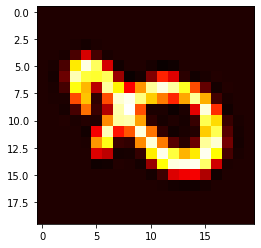

----------------------------------
Label: 	 [8]
Predição: 0


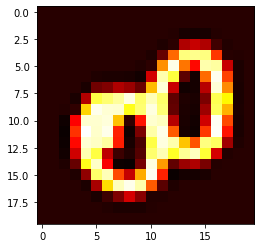

----------------------------------
Label: 	 [8]
Predição: 9


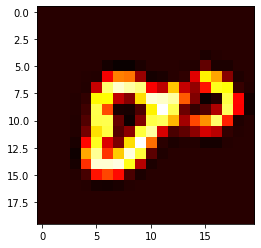

----------------------------------
Label: 	 [8]
Predição: 3


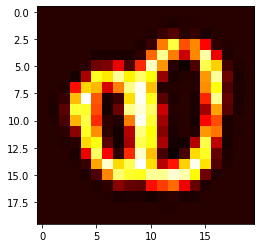

----------------------------------
Label: 	 [8]
Predição: 5


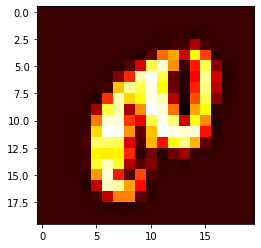

----------------------------------
Label: 	 [8]
Predição: 5


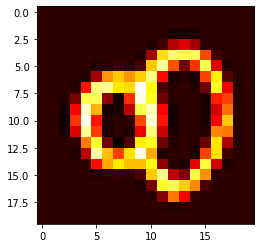

----------------------------------
Label: 	 [8]
Predição: 5


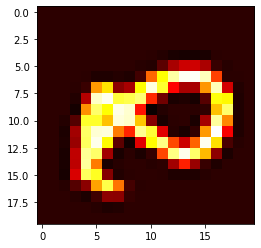

----------------------------------
Label: 	 [8]
Predição: 4


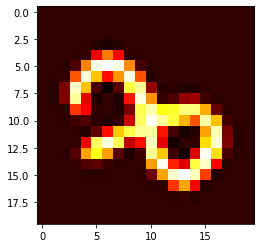

----------------------------------
Label: 	 [8]
Predição: 2


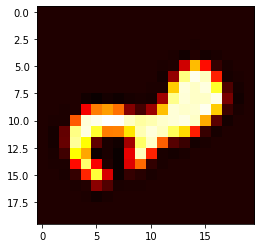

----------------------------------
Label: 	 [8]
Predição: 3


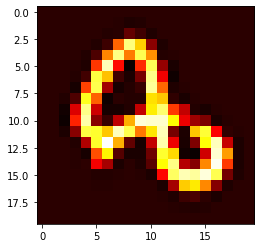

----------------------------------
Label: 	 [8]
Predição: 5


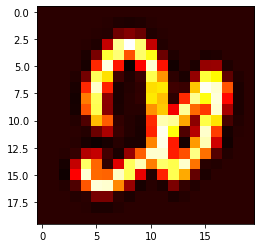

----------------------------------
Label: 	 [8]
Predição: 2


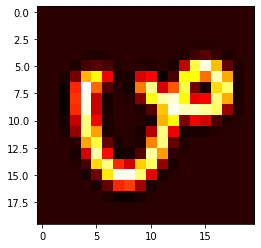

----------------------------------
Label: 	 [8]
Predição: 6


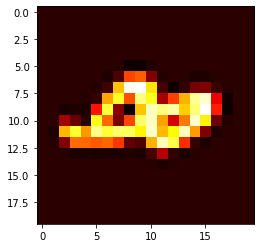

----------------------------------
Label: 	 [8]
Predição: 6


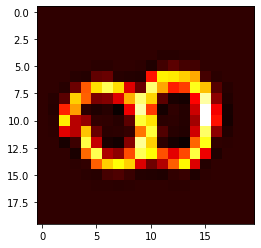

----------------------------------
Label: 	 [8]
Predição: 4


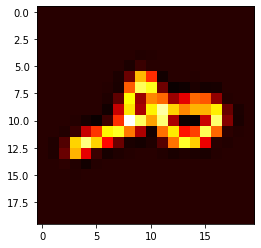

----------------------------------
Label: 	 [8]
Predição: 2


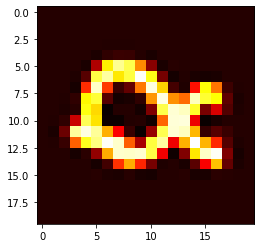

----------------------------------
Label: 	 [8]
Predição: 3


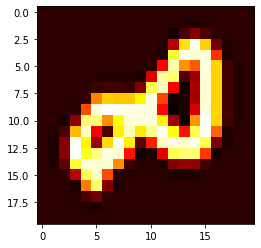

----------------------------------
Label: 	 [9]
Predição: 7


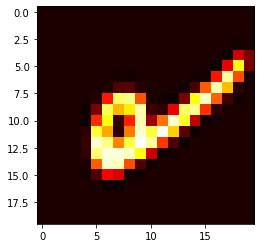

----------------------------------
Label: 	 [9]
Predição: 5


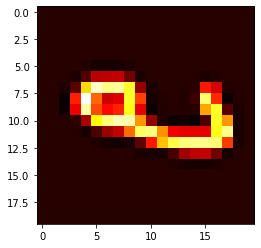

----------------------------------
Label: 	 [9]
Predição: 0


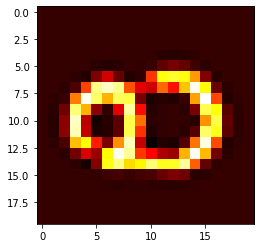

----------------------------------
Label: 	 [9]
Predição: 7


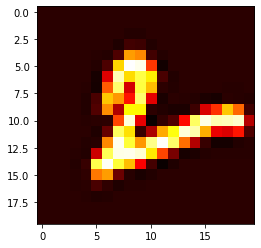

----------------------------------
Label: 	 [9]
Predição: 7


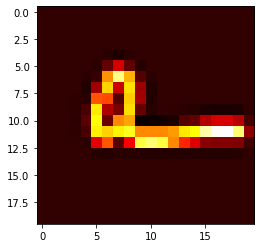

----------------------------------
Label: 	 [9]
Predição: 7


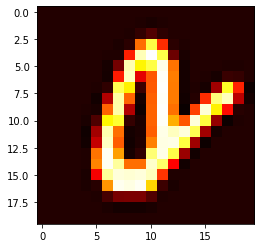

----------------------------------
Label: 	 [9]
Predição: 8


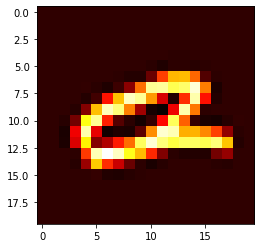

----------------------------------
Label: 	 [9]
Predição: 7


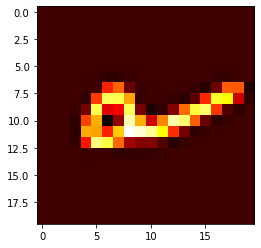

----------------------------------
Label: 	 [9]
Predição: 0


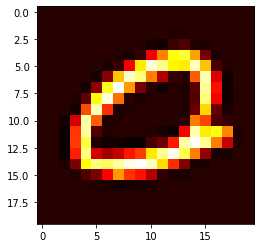

----------------------------------
Label: 	 [9]
Predição: 7


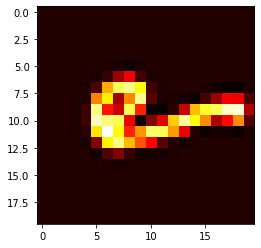

----------------------------------
Label: 	 [9]
Predição: 3


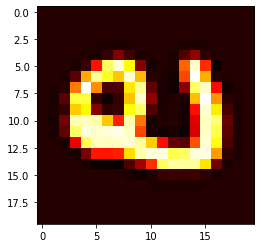

----------------------------------
Label: 	 [9]
Predição: 3


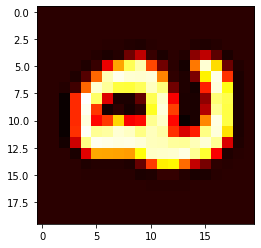

----------------------------------
Label: 	 [9]
Predição: 4


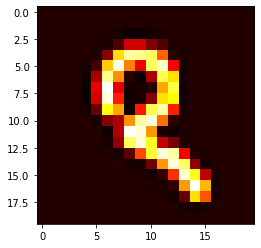

----------------------------------
Label: 	 [9]
Predição: 7


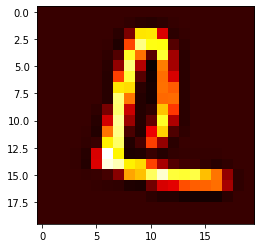

----------------------------------
Label: 	 [9]
Predição: 0


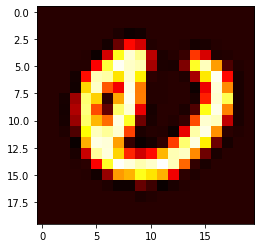

----------------------------------
Label: 	 [9]
Predição: 7


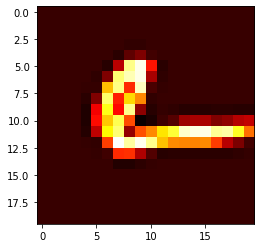

----------------------------------
Label: 	 [9]
Predição: 0


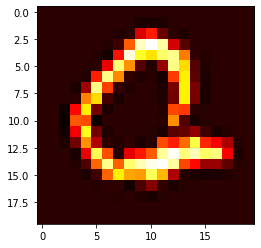

----------------------------------
Label: 	 [9]
Predição: 2


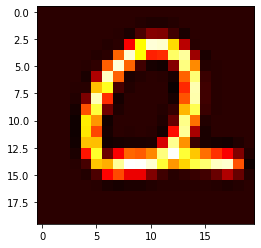

----------------------------------
Label: 	 [9]
Predição: 7


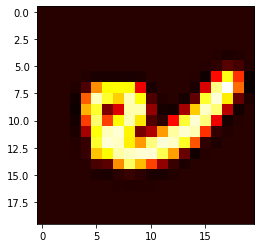

----------------------------------
Label: 	 [9]
Predição: 6


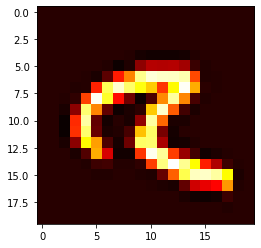

----------------------------------
Label: 	 [9]
Predição: 7


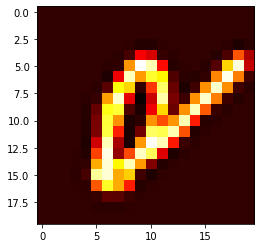

----------------------------------
Label: 	 [9]
Predição: 5


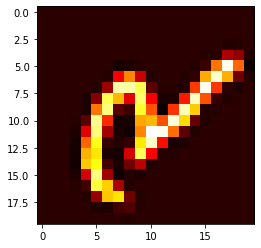

----------------------------------
Label: 	 [9]
Predição: 3


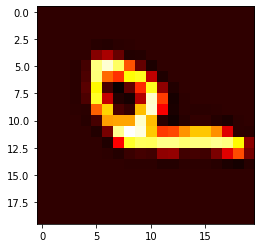

----------------------------------
Label: 	 [9]
Predição: 3


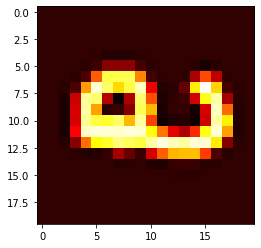

----------------------------------
Label: 	 [9]
Predição: 1


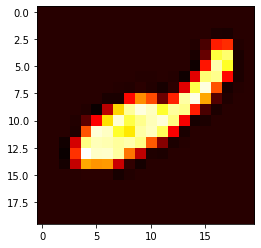

----------------------------------
Label: 	 [9]
Predição: 1


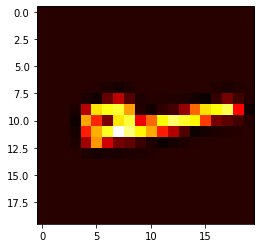

----------------------------------
Label: 	 [9]
Predição: 7


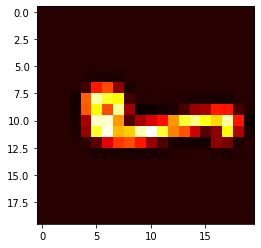

----------------------------------
Label: 	 [9]
Predição: 8


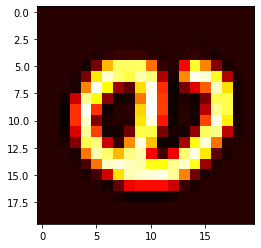

----------------------------------
Label: 	 [9]
Predição: 7


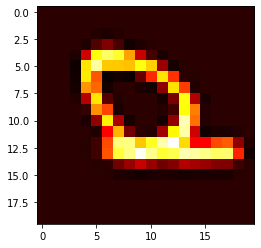

----------------------------------
Label: 	 [9]
Predição: 4


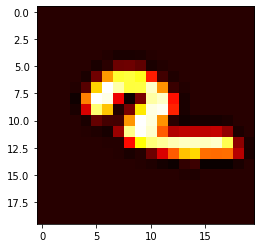

----------------------------------
Label: 	 [9]
Predição: 0


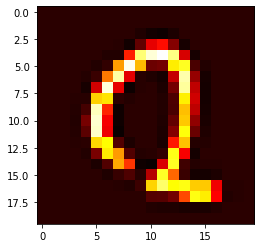

----------------------------------
Label: 	 [9]
Predição: 0


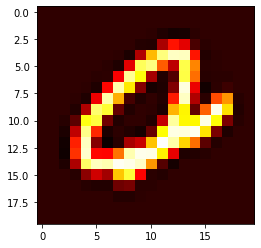

----------------------------------
Label: 	 [9]
Predição: 3


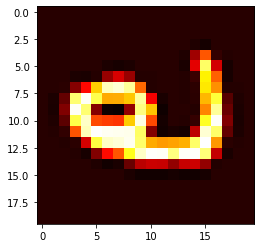

----------------------------------


In [18]:
miss_feedback(X, Y, pred)

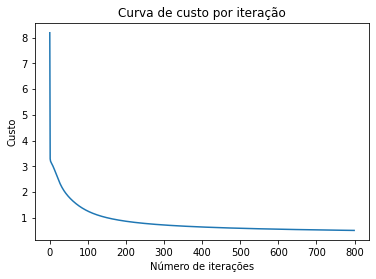

In [19]:
def plot_J_history(J_history):
    plt.plot(J_history)
    plt.xlabel('Número de iterações')
    plt.ylabel('Custo')
    plt.title('Curva de custo por iteração')
    plt.show()
    
plot_J_history(J_history)

### 4.F Visualizar imagens de Θ(1)

> A i-ésima linha de Θ(1) é um vetor de 401 elementos. Descartando-se o bias, temos um vetor de 400 elementos, o qual pode ser rearranjado para uma imagem 20×20. Esta imagem é uma representação visual da forma como cada unidade escondida atua na rede. Mostre esta imagem para cada unidade escondida. Normalize (scaling) os valores de cada imagem entre 0 e 1 para facilitar a visualização.

Podemos criar uma função que exibe a imagem em tal passo intermediário, de forma a visualizarmos quais são as imagens obtidas após uma camada de processamento:

In [20]:
def image_visualization(thetas):
    visu = cp.deepcopy(thetas[0])
    
    for i in range(visu.shape[0]):
        visu[i,1:]=(visu[i,1:]-np.min(visu[i,1:]))/(np.max(visu[i,1:])-np.min(visu[i,1:]))
        plt.figure()
        plt.imshow(visu[i,1:].reshape(20,20),cmap="gray")
        plt.title("Unidade Escondida {}".format(i+1))
        plt.show()   

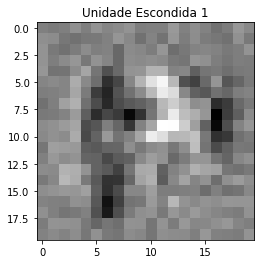

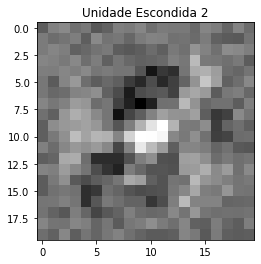

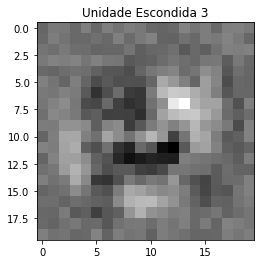

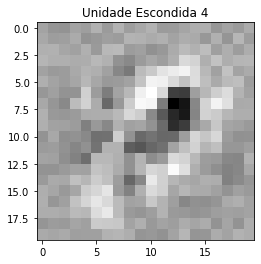

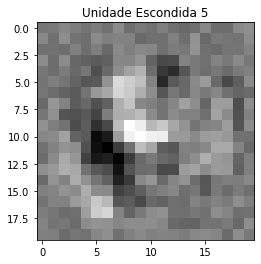

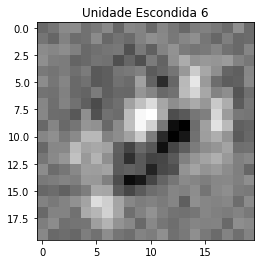

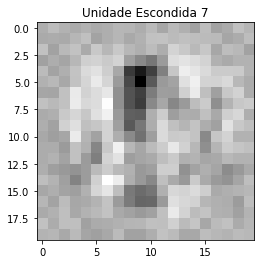

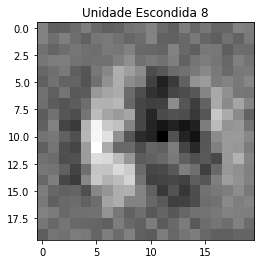

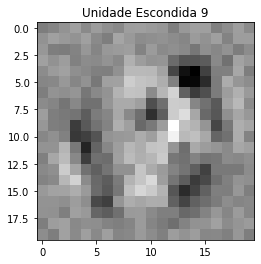

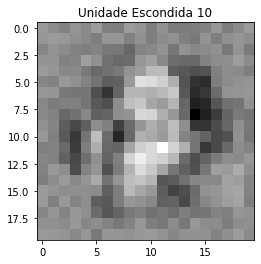

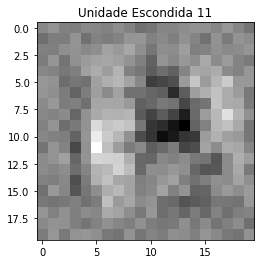

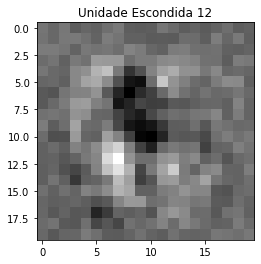

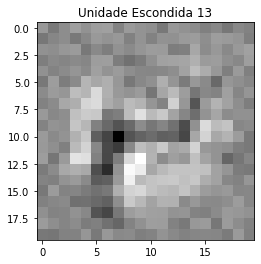

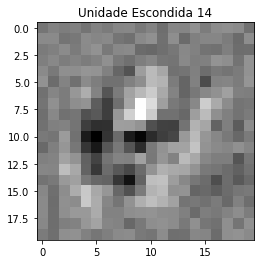

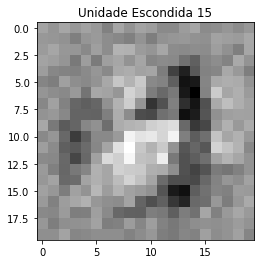

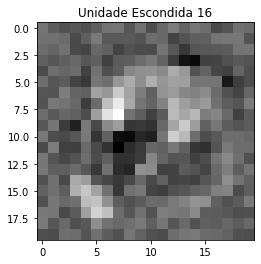

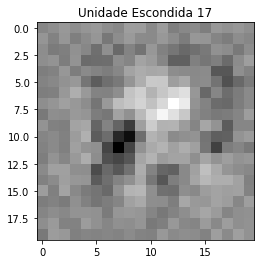

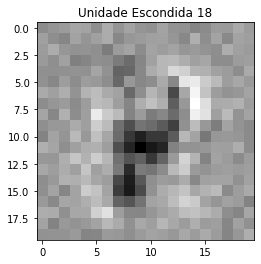

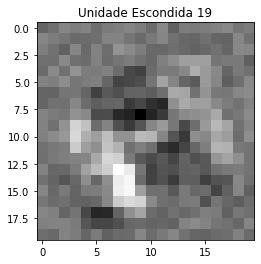

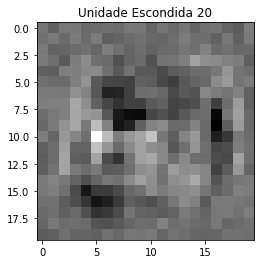

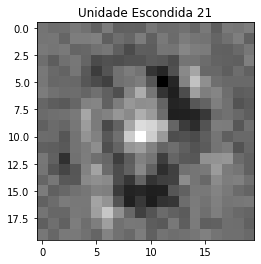

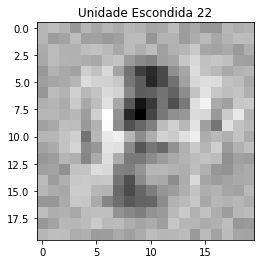

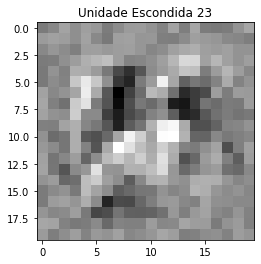

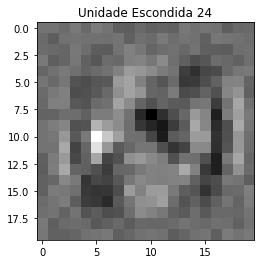

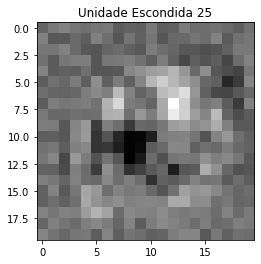

In [21]:
image_visualization(new_Thetas)